In [1]:
# Configuration
PROCESSED_DATA_PATH = "../data/processed/1_preprocessed_data.pkl"
MODEL_SAVE_PATH = "../data/models/production/"
PREDICTIONS_OUTPUT_PATH = "../data/predictions/"

# Model configuration
MODEL_NAME = "logistic_regression_production"
MODEL_VERSION = "v0.1"
RANDOM_STATE = 42

In [2]:
# Load packages
import pandas as pd
import numpy as np
import pickle
import joblib
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix,
    roc_curve, auc
)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Functions

In [3]:
def evaluate_model_performance(y_true, y_pred, y_score, model_name="Model", plot_roc=True):
    """
    Comprehensive model evaluation with metrics and visualizations.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_score : array-like
        Prediction probabilities for positive class
    model_name : str
        Name of the model for display purposes
    plot_roc : bool
        Whether to plot ROC curve
    
    Returns:
    --------
    dict : Dictionary containing all metrics
    """
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score)
    f1_pos = f1_score(y_true, y_pred, pos_label=1)
    f1_neg = f1_score(y_true, y_pred, pos_label=-1)
    
    # Classification report
    report = classification_report(y_true, y_pred, 
                                 target_names=['Class -1', 'Class +1'])
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class -1', 'Class +1'], 
                yticklabels=['Class -1', 'Class +1'])
    plt.title(f'Confusion Matrix ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Plot ROC curve if requested
    if plot_roc:
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
        roc_auc_val = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc_val:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve ({model_name})')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Print metrics
    print(f"=== {model_name} Performance Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"F1 Score (Class +1): {f1_pos:.4f}")
    print(f"F1 Score (Class -1): {f1_neg:.4f}")
    print("\nClassification Report:")
    print(report)
    
    return {
        'accuracy': acc,
        'roc_auc': roc_auc,
        'f1_positive': f1_pos,
        'f1_negative': f1_neg,
        'confusion_matrix': cm,
        'classification_report': report
    }

def save_model_artifacts(model, preprocessors, metrics, model_path, model_name):
    """
    Save model and associated artifacts for production deployment.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model object
    preprocessors : dict
        Dictionary containing preprocessing objects
    metrics : dict
        Dictionary containing model performance metrics
    model_path : str
        Directory path to save model artifacts
    model_name : str
        Name identifier for the model
    
    Returns:
    --------
    tuple : Paths to saved model, preprocessors, and metrics files
    """
    # Create directory if it doesn't exist
    Path(model_path).mkdir(parents=True, exist_ok=True)
    
    # Save model
    model_file = os.path.join(model_path, f"{model_name}_model.pkl")
    joblib.dump(model, model_file)
    print(f"Model saved to: {model_file}")
    
    # Save preprocessors
    preprocessors_file = os.path.join(model_path, f"{model_name}_preprocessors.pkl")
    joblib.dump(preprocessors, preprocessors_file)
    print(f"Preprocessors saved to: {preprocessors_file}")
    
    # Save metrics
    metrics_file = os.path.join(model_path, f"{model_name}_metrics.pkl")
    joblib.dump(metrics, metrics_file)
    print(f"Metrics saved to: {metrics_file}")
    
    return model_file, preprocessors_file, metrics_file

# Initialize

## Create directories

In [4]:
# Create necessary directories
Path(MODEL_SAVE_PATH).mkdir(parents=True, exist_ok=True)
Path(PREDICTIONS_OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

print(f"Model save directory: {MODEL_SAVE_PATH}")
print(f"Predictions output directory: {PREDICTIONS_OUTPUT_PATH}")

Model save directory: ../data/models/production/
Predictions output directory: ../data/predictions/


## Load processed data

In [5]:
# Load processed data
print("Loading processed data...")
with open(PROCESSED_DATA_PATH, 'rb') as f:
    processed_data = pickle.load(f)

print("Available keys in processed data:")
for key in processed_data.keys():
    print(f"  - {key}")

Loading processed data...
Available keys in processed data:
  - X_train_original
  - y_train_original
  - X_train_balanced
  - y_train_balanced
  - y_train_transformed
  - y_train_balanced_transformed
  - X_test
  - feature_selector
  - scaler
  - variance_selector
  - xgb_label_encoder
  - class_weight_dict
  - scale_pos_weight
  - smote


In [6]:
# Unpack data components
X_train_balanced = processed_data['X_train_balanced']
y_train_balanced = processed_data['y_train_balanced']
X_test = processed_data['X_test']

# Preprocessing components
feature_selector = processed_data['feature_selector']
scaler = processed_data['scaler']
variance_selector = processed_data['variance_selector']

print(f"Training set shape: {X_train_balanced.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training set:")
print(pd.Series(y_train_balanced).value_counts().sort_index())

Training set shape: (6754, 2000)
Test set shape: (1250, 2000)
Class distribution in training set:
-1    3377
 1    3377
Name: count, dtype: int64


# Model Training & Validation

## Logistic Regression - Production Model

In [7]:
# Initialize and train Logistic Regression model
print("Training Logistic Regression model...")

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    solver='liblinear',
    class_weight='balanced'
)

# Fit the model
lr_model.fit(X_train_balanced, y_train_balanced)

print(f"Model training completed.")
print(f"Model parameters: {lr_model.get_params()}")

Training Logistic Regression model...
Model training completed.
Model parameters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Cross-Validation Evaluation

In [8]:
# Perform 5-fold cross-validation
print("Performing 5-fold cross-validation...")

# Cross-validation predictions and probability scores
y_pred_cv_lr = cross_val_predict(lr_model, X_train_balanced, y_train_balanced, cv=5)
y_score_lr = cross_val_predict(lr_model, X_train_balanced, y_train_balanced, 
                              cv=5, method='predict_proba')[:, 1]

print("Cross-validation completed.")
print(f"CV Predictions shape: {y_pred_cv_lr.shape}")
print(f"CV Scores shape: {y_score_lr.shape}")

Performing 5-fold cross-validation...
Cross-validation completed.
CV Predictions shape: (6754,)
CV Scores shape: (6754,)


## Model Performance Evaluation

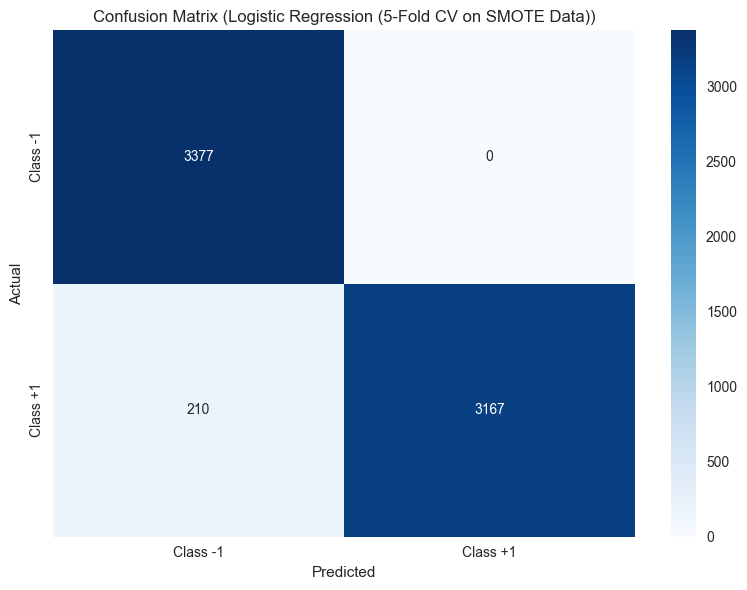

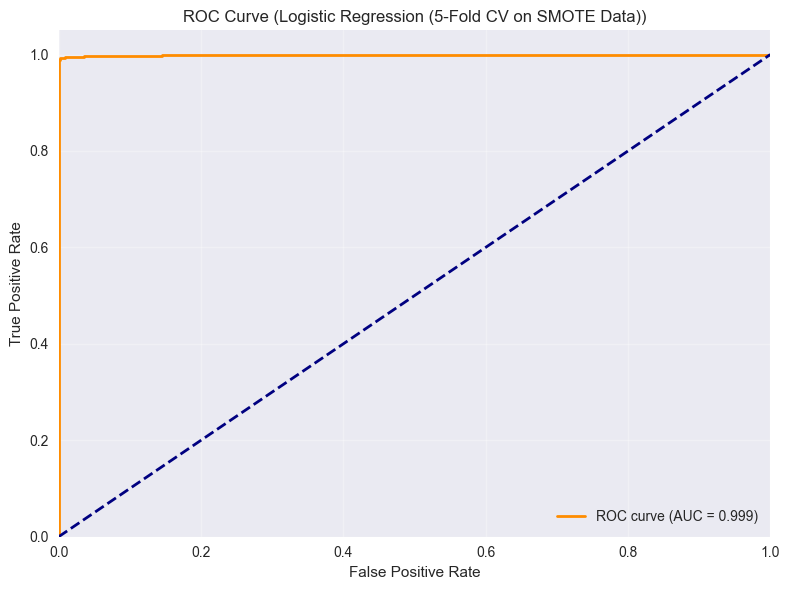

=== Logistic Regression (5-Fold CV on SMOTE Data) Performance Metrics ===
Accuracy: 0.9689
ROC-AUC: 0.9992
F1 Score (Class +1): 0.9679
F1 Score (Class -1): 0.9698

Classification Report:
              precision    recall  f1-score   support

    Class -1       0.94      1.00      0.97      3377
    Class +1       1.00      0.94      0.97      3377

    accuracy                           0.97      6754
   macro avg       0.97      0.97      0.97      6754
weighted avg       0.97      0.97      0.97      6754



In [9]:
# Comprehensive model evaluation
lr_metrics = evaluate_model_performance(
    y_train_balanced, 
    y_pred_cv_lr, 
    y_score_lr,
    model_name="Logistic Regression (5-Fold CV on SMOTE Data)"
)

# Model Selection for Production

## Selection Rationale

After extensive experimentation with various models and class balancing strategies, both linear SVM and logistic regression showed strong performance on the SMOTE-balanced training set and produced non-trivial predictions for both classes on the test set. Their results were very similar, indicating the data is linearly separable after balancing.

**Deploying Logistic Regression for the following reasons:**

- **Probability Calibration**: Provides well-calibrated probability outputs, which are valuable for downstream decision-making and risk assessment
- **Interpretability**: Highly interpretable, allowing us to explain predictions to stakeholders
- **Computational Efficiency**: Computationally efficient and easy to maintain in production environments
- **Operational Simplicity**: Offers the best balance of performance, interpretability, and operational simplicity

**Alternative Consideration**: SVM (linear) is a strong alternative and may be considered if maximizing the margin is a priority or if future data becomes less linearly separable.

## Generating predictions 

-- we don't need here the notebooks explains the problem and justifies your way of
getting to the final solution but in `src` we have all steps to generate predication `test_labels.csv`